# Libraries

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import scipy.stats
import random

#Set seed to replicate results
np.random.seed(100)

###### Some of the tests use realized variance and bipower variance. To avoid overlap, define a function that can be used for RV/BV calculation

In [5]:
def realized_var(rt:np.array):
    "Calculate the realized variance of the returns"
    RV = np.sum(np.power(rt, 2))
    return RV

In [6]:
def bipower_var(rt : np.array):
    M = len(rt)
    BV = (np.pi/2) * (M/(M-1)) * np.sum(np.abs(rt[1:] *np.abs(rt[:-1])))
    return BV

# Tests based on squared variation

##### Barndorff-Nielsen and Shephard (2006) Test (BNS)

In [7]:
def BNS(rt : np.array):
    """
    Return the tests statistic defined in Barndorff-Nielsen and Shephard (2006)
    
    Code source : Maneesoonthorn, Worapree, Gael M. Martin, and Catherine S. Forbes. 
                  "High-frequency jump tests: Which test should we use?." Journal of econometrics 219.2 (2020): 478-487.

    """
    M = len(rt)
    
    RV = realized_var(rt)
    BV = bipower_var(rt)
    
    constant = ((2**(2/3))*math.gamma(7/6)*(math.gamma(1/2)**(-1/2)))**(-3)
    temp = np.sum(np.abs(rt[:-2])**(4/3) * np.abs(rt[1:-1])**(4/3) * np.abs(rt[2:])**(4/3))
    
    TP = constant * (M**2/(M-2)) * temp
    
    numerator = 1 - (BV/RV)
    denumerator = np.sqrt(((np.pi/2)**2 + np.pi - 5) * M**-1 * max(1, (TP/BV**2)))
    
    test = numerator / denumerator
    
    return test

##### Corsi, Pirino, and Reno (2010) Test (CPR)

In [8]:
def CPR(rt: np.array,K: int, c: int):
    
    """
    Return the tests statistic defined in Corsi, Pirino, and Reno (2010) 
    
    
    Code source : Maneesoonthorn, Worapree, Gael M. Martin, and Catherine S. Forbes. 
                  "High-frequency jump tests: Which test should we use?." Journal of econometrics 219.2 (2020): 478-487.
                  The authors used K = 10 and c = 3
    """
    
    M = len(rt)
    RV = realized_var(rt)
    
    temp = np.multiply(np.abs(rt[:-1]), np.abs(rt[1:]))
    Vti = np.zeros(M-K-1)
    
    for i in range(M-K-1):
        Vti[i] = (np.pi/2) *(1/(K-1)) * np.sum(temp[i: i+K+1])
    
    psi = (c**2) * Vti
    r = rt[K+1:]
    
    tau1 = np.where(r <= np.sqrt(psi), np.abs(r), 1.094*np.sqrt(psi))
    tau43 = np.where(r <= np.sqrt(psi), np.abs(r)** (4/3), 1.129 * psi**(2/3))
    
    Mn = len(tau1) 
    CTBV = (np.pi/2) * (Mn / (Mn-1)) * np.sum(tau1[:-1] * tau1[1:])
    constant = ((2**(2/3))*math.gamma(7/6)*(math.gamma(1/2)**(-1/2)))**(-3)
    
    temp2 = np.sum(tau43[0:-2]*tau43[1:-1]*tau43[2:])
    CTPV = constant * (Mn**2 / (Mn-2)) * temp2
    
    numerator = 1 - (CTBV/RV)
    denumerator = ((np.pi/2) **2 + np.pi - 5) * (1/Mn) * max(1, CTPV/CTBV**2)
    
    test = numerator / np.sqrt(denumerator)
    
    return test

##### Andersen, Dobrev, and Schaumburg (2009) Tests Based on MinRV

In [9]:
def TMIN(rt : np.array):  
    """
    Andersen, Dobrev, and Schaumburg (2009)
    
    Code source : Maneesoonthorn, Worapree, Gael M. Martin, and Catherine S. Forbes. 
                  "High-frequency jump tests: Which test should we use?." Journal of econometrics 219.2 (2020): 478-487.
    """
    
    #Length of the (log) return series
    M = len(rt)
    
    #Calculate realized variance
    RV = realized_var(rt)
    
    temp = np.minimum(np.abs(rt[1:]),np.abs(rt[:-1]))
    MinRV = (np.pi/(np.pi-2))*(M/(M-1)) *np.sum(temp**2)
    
    MinRQ = (np.pi/(3*np.pi-8))* (M**2/(M-1)) *np.sum(temp**4)
    
    numerator = 1 - (MinRV/RV)
    denumerator = np.sqrt((1.81/M) * max(1,(MinRQ/(MinRV**2))))

    test = numerator / denumerator
    return test

##### Andersen, Dobrev, and Schaumburg (2009) Tests Based on MedRV

In [10]:
def TMED(rt : np.array):
    """
    Andersen, Dobrev, and Schaumburg (2009)
    
    Code source : Maneesoonthorn, Worapree, Gael M. Martin, and Catherine S. Forbes. 
                  "High-frequency jump tests: Which test should we use?." Journal of econometrics 219.2 (2020): 478-487.
    """
    M = len(rt)
    RV = realized_var(rt)
    data_med = np.stack([np.abs(rt[0:M-2]), np.abs(rt[1:M-1]), np.abs(rt[2:])])
    constant_medrv = np.pi /(np.pi + 6 - 4*np.sqrt(3)) * (M/(M-2))
    MedRV = constant_medrv * np.sum(np.median(data_med, axis = 0)**2)
    
    constant_medrq = 3*np.pi/(9*np.pi + 72 - 52*np.sqrt(3)) * (M**2/(M-2))
    MedRQ = constant_medrq * np.sum(np.median(data_med,axis = 0)**4)
    
    numerator = 1 - (MedRV/RV)
    denumerator = np.sqrt(0.96/M *max(1,(MedRQ/MedRV**2)))
    test = numerator / denumerator
    
    return test

## Tests based on P-power variation

##### Podolskij and Ziggel (2010) Test (Two variations)

In [11]:
def PZ2(rt : np.array, tau: int):
    """
    Podolskij and Ziggel (2010) 
    
    Code source : Maneesoonthorn, Worapree, Gael M. Martin, and Catherine S. Forbes. 
                  "High-frequency jump tests: Which test should we use?." Journal of econometrics 219.2 (2020): 478-487.
    
    """
    M = len(rt)
    BV = bipower_var(rt)
    trunc = 2.3 * np.sqrt(BV) * ((1/M)**(0.4))

    unif = np.random.uniform(size = M)
    eta = np.where(unif <= 0.5, 1-tau, 1+tau)

    Bhat2 = np.sqrt(M) * np.sum(np.abs(rt)**2 * (1 - eta *np.where(np.abs(rt) < trunc, 1, 0)))
    Vbar4 = M * np.sum(np.where(np.abs(rt) < trunc,rt **4,0))
    var2 = np.var(eta, ddof = 1) * Vbar4 #Need to set degrees of freedom to 1
    
    test = Bhat2/np.sqrt(var2)
    
    return test

In [12]:
def PZ4(rt : np.array, tau: int):
    """
    Podolskij and Ziggel (2010) 
    
    Code source : Maneesoonthorn, Worapree, Gael M. Martin, and Catherine S. Forbes. 
                  "High-frequency jump tests: Which test should we use?." Journal of econometrics 219.2 (2020): 478-487.
    Tau?
    """
    M = len(rt)
    BV = bipower_var(rt)
    trunc = 2.3 * np.sqrt(BV) * ((1/M)**(0.4))

    unif = np.random.uniform(size = M)
    eta = np.where(unif <= 0.5, 1-tau, 1+tau)

    Bhat4 =M**(3/2) * np.sum(np.abs(rt)**4 * (1 - eta *np.where(np.abs(rt) < trunc, 1, 0)))
    Vbar8 = M**3 * np.sum(np.where(np.abs(rt) < trunc,rt **8,0))
    var4 = np.var(eta,ddof = 1) * Vbar8
    
    test = Bhat4/np.sqrt(var4)
    
    return test

##### The Ait-Sahalia and Jacod (2008) Test (ASJ)

In [13]:
def ASJ(rt : np.array):
    """
    Ait-Sahalia and Jacod (2008) 
    
    Code source : Maneesoonthorn, Worapree, Gael M. Martin, and Catherine S. Forbes. 
                  "High-frequency jump tests: Which test should we use?." Journal of econometrics 219.2 (2020): 478-487.
    """
    M = len(rt)
    K= 10
    temp = np.multiply(np.abs(rt[:-1]), np.abs(rt[1:]))
    Vti = np.zeros(M-K-1)
    
    for i in range(M-K-1):
        Vti[i] = (np.pi/2) *(1/(K-1)) * np.sum(temp[i: i+K+1])

    mp = 3
    m2p = 105
    Mpk = (16 * 2) * (2*4-2-1)/3

    tempr = rt[M-len(Vti):M]
    #Define M for further calculation
    M = len(tempr)
    rtk = tempr[1::2]
    
    Bhat = np.sum(np.abs(np.power(tempr,4)))
    Bhatk = np.sum(np.abs(np.power(rtk,4)))
    Shat = Bhat / Bhatk
    
    trunc = 3*np.sqrt(Vti*M)*((1/M)**0.48)
    Ahat = (M/mp) * np.sum(np.abs(np.power(tempr,4)) * np.where(np.abs(tempr) < trunc,1,0))
    Ahat2 = ((M**3)/m2p) * np.sum(np.abs(np.power(tempr,8)) * np.where(np.abs(tempr) < trunc,1,0))
    
    Sig = (1/M) * Mpk * Ahat2 / (Ahat**2)
    test = (Shat - 2) /np.sqrt(Sig)
    
    return test

## Tests based on standardized returns

##### Andersen, Bollerslev, and Dobrev (2007)

In [14]:
def ABD(rt : np.array):
    """
    Andersen, Bollerslev, and Dobrev (2007)
    
    Code source : Maneesoonthorn, Worapree, Gael M. Martin, and Catherine S. Forbes. 
                  "High-frequency jump tests: Which test should we use?." Journal of econometrics 219.2 (2020): 478-487.
    """
    M = len(rt)
    BV = bipower_var(rt)
    
    vals = rt / np.sqrt(BV/M)
    return np.max(np.abs(vals))

##### Lee and Mykland (2008)

In [15]:
def LM(rt):
    """
    Lee and Mykland (2008) 
    
    Code source : Maneesoonthorn, Worapree, Gael M. Martin, and Catherine S. Forbes. 
                  "High-frequency jump tests: Which test should we use?." Journal of econometrics 219.2 (2020): 478-487.
    """
    M = len(rt)
    K = 10
    
    
    temp = np.multiply(np.abs(rt[:-1]), np.abs(rt[1:]))
    Vti = np.zeros(M-K-1)
    
    for i in range(M-K-1):
        Vti[i] = (np.pi/2) *(1/(K-1)) * np.sum(temp[i: i+K+1])
    
    tempr = rt[M-len(Vti): M]
    Ttil = np.abs(tempr) / np.sqrt(Vti)
    
    Cm = (np.sqrt(2*np.log(M))/0.8)-((np.log(np.pi)+np.log(np.log(M)))/(1.6*np.sqrt(2*np.log(np.pi))))
    Sm=1/(0.6*np.sqrt(2*np.log(np.pi)))
    LM=(np.max(Ttil)-Cm)/Sm;
    
    return LM

## Tests based on variance swap

##### Jiang and Oomen (2008) Test

In [16]:
def JO(log_returns:np.array):
    """
    Jiang and Oomen (2008) Test
    
    Code source : Maneesoonthorn, Worapree, Gael M. Martin, and Catherine S. Forbes. 
                  "High-frequency jump tests: Which test should we use?." Journal of econometrics 219.2 (2020): 478-487.
    """

    
    returns = np.exp(log_returns)-1
 
    #Length of the return series
    M = len(log_returns)

    #Initialize a temporary variable
    temp = (               
                (np.absolute(log_returns[0:len(log_returns)-3]) *
                np.absolute(log_returns[1:len(log_returns)-2]) *
                np.absolute(log_returns[2:len(log_returns)-1]) *
                np.absolute(log_returns[3:len(log_returns)])) ** (3/2)
            )

    #Calculate Sigma in the definition
    Sigma = 3.05 * ((M**3) / (M-3)) * np.sum(temp)

    # Calculate SWV in the definition
    SWV = 2* np.sum(returns - log_returns)
    
    #Calculate bipower variation and realized variance
    BV = bipower_var(log_returns)
    RV = realized_var(log_returns)

    #Calculate the test statistic
    test_stat = ((M*BV)/np.sqrt(Sigma))*(1 - (RV/SWV))
    return test_stat

# Data Generating Process
Based on Maneesoonthorn (2016)

In [243]:
def DGP_Maneesoonthorn(mu = 0,kappa = 5, rho = -0.5, theta = 0.16, sigma_v = 0.5, sec = 300,
                       price_jump ="No", volatility_jump = "No", noise = "No"):

    dt = 1/21600

    #Generate multivariate normal variables
    W = np.random.multivariate_normal(mean = [0, 0],
                                      cov = [[dt,dt* rho],[dt* rho,dt]],
                                      size = 21600)
 
    #Generate the volatility process
    v = np.zeros(21600)
    #First value equals as per the paper
    v[0] = theta

    for i in range(1,21600):
        #The multiplier of sqrt(dt) comes from the discretization of a Brownian motion
        v[i] =  v[i-1] + kappa * (theta - v[i - 1] ) * dt + sigma_v * np.sqrt(v[i-1]) * W[i,0] 

    
    #Volatility jump construction
    vj_loc = int(np.random.randint(0,21600,1)) #Needs to be an integer so we can index
    
    if volatility_jump == "No":
        pass
    
    elif volatility_jump == "M":
        v[vj_loc:] = v[vj_loc:] + 3 * theta
        
    elif volatility_jump == "L":
        v[vj_loc:] = v[vj_loc:] + 10 * theta
    
    
    #Generate the returns
    r = np.zeros(21600)
    for i in range(21600):
        r[i] = mu * dt + np.sqrt(v[i]) *  W[i,1]
    
    #Price jump construction
    pj_loc = np.random.randint(0,21600,1)
    
    #THIS NEEDS CONSULTING
    if price_jump == "No":
        pass
        
    elif price_jump == "M": #Moderate jump
        r[pj_loc] = r[pj_loc] + 3 * np.sqrt(theta/252)
        
    elif price_jump == "L":
        r[pj_loc] = r[pj_loc] + 10 * np.sqrt(theta/252)
    
    #Generate noise as in Yacine Aït-Sahalia  Jean Jacodc, Jia Li (2012)
    if noise == "No":
        pass
    
    if noise == "Gaussian":
        nt = 2 * np.sqrt(dt * v) * np.random.normal(loc = 0.0, scale = 1.0, size = 21600)
        r = r + nt
        
    if noise == "Student":
        df = 2.5
        nt = (2/np.sqrt(df/(df-2))) * np.sqrt(dt*v) * np.random.standard_t(df,21600)
        r = r + nt
        
    #Take the cummulative sum of the return process and take every "sec" th element
    r = np.add.reduceat(r, np.arange(0,len(r),sec))
    return r

In [18]:
def DGP_SV1F(alpha = -0.100, corr = -0.62):
    """
    This DGP is based on the SV1F proposed in Dumitru and Urga (2012). The correlation parameter is fixed 
    at -0.62 in the original paper,however for parameter alpha 3 different values were used. This way we 
    only simulate the continuous part, that is used for example in the test size analysis.

    Output - np.array of length 72
    """

    #Generate multivariate normal variables
    W = np.random.multivariate_normal(mean = [0, 0],
                                      cov = [[1,-0.62],[-0.62,1]],
                                      size = 21600)

    #Define the stepsize
    dt = 1/21600

    #Generate the volatility process
    v = np.zeros(21600)
    v[0] = (0.16)
    #Define the mean reversion parameter / Use one of Dimitru's value
    alpha = -0.100
    for i in range(1,21600):
        #The multiplier of sqrt(dt) comes from the discretization of a Brownian motion
        v[i] = v[i - 1] + alpha * v[i - 1]*dt + np.sqrt(dt) * W[i,0]

    #Generate the price process
    p = np.zeros(21600)
    for i in range(21600):
        p[i] = 0.03 * dt + np.exp(0.125 * v[i]) * np.sqrt(dt) * W[i,1]

    #Take the cummulative sum of the price process and take every 300th element
    p = np.add.reduceat(p, np.arange(0,len(p),300))
    return p


# Testing Area
The 5 minute inverval is examined

## Compare to Maneesoonthorn

In [310]:
n = 1000 #number of simulations

#Define lists to save results
ered_BNS = np.array([])
ered_cpr = np.array([])
ered_min = np.array([])
ered_med = np.array([])
ered_pz2 = np.array([])
ered_pz4 = np.array([])
ered_asj = np.array([])
ered_abd = np.array([])
ered_lm = np.array([])
ered_jo = np.array([])


for i in range(n):
    #Simulate rt
    r = DGP_Maneesoonthorn(price_jump = "L", volatility_jump = "L")
        
    #Calculate test stat and save to list
    test_BNS = BNS(r)
    ered_BNS = np.append(ered_BNS, test_BNS)
    
    test_cpr = CPR(r, 10,3)
    ered_cpr = np.append(ered_cpr, test_cpr)
    
    test_min = TMIN(r)
    ered_min = np.append(ered_min, test_min)
    
    test_med = TMED(r)
    ered_med = np.append(ered_med, test_med)

    test_pz2 = PZ2(r,0.001)
    ered_pz2 = np.append(ered_pz2, test_pz2)

    test_pz4 = PZ4(r,0.001)
    ered_pz4 = np.append(ered_pz4, test_pz4)
    
    test_asj = ASJ(r)
    ered_asj = np.append(ered_asj, test_asj)
    
    test_abd = ABD(r)
    ered_abd = np.append(ered_abd, test_abd)
    
    test_lm = LM(r)
    ered_lm = np.append(ered_lm, test_lm)
    
    test_jo = JO(r)
    ered_jo = np.append(ered_jo, test_jo)

In [309]:
#Comparing to Maneesoonthorn
display(f"Size of BNS: {np.sum(ered_BNS >= 1.644854)/n}. Original size : 0.055")
display(f"Size of CPR: {np.sum(ered_cpr >= 1.644854)/n}. Original size : 0.464")
display(f"Size of TMIN: {np.sum(ered_min >= 1.644854)/n}. Original size : 0.044")
display(f"Size of TMED: {np.sum(ered_med >= 1.644854)/n}. Original size : 0.060")
display(f"Size of PZ2: {np.sum(ered_pz2 >= 1.644854)/n}. Original size : 0.092")
display(f"Size of PZ4: {np.sum(ered_pz4 >= 1.644854)/n}. Original size : 0.078")
display(f"Size of ASJ: {np.sum(ered_asj <= -1.644854)/n}. Original size : 0.000")
display(f"Size of ABD: {np.sum(ered_abd >= 3.3848571)/n}. Original size : 0.063")
display(f"Size of LM: {np.sum(ered_lm >= 2.970195)/n}. Original size : 0.005")
display(f"Size of JO: {np.sum(np.abs(ered_jo) >= 1.96)/n}. Original size : 0.079")

'Size of BNS: 0.209. Original size : 0.055'

'Size of CPR: 0.316. Original size : 0.464'

'Size of TMIN: 0.125. Original size : 0.044'

'Size of TMED: 0.161. Original size : 0.060'

'Size of PZ2: 0.436. Original size : 0.092'

'Size of PZ4: 0.426. Original size : 0.078'

'Size of ASJ: 0.0. Original size : 0.000'

'Size of ABD: 0.476. Original size : 0.063'

'Size of LM: 0.103. Original size : 0.005'

'Size of JO: 0.171. Original size : 0.079'

## Compare to Dimitru

In [ ]:
n = 1000 #number of simulations

#Define lists to save results
ered_BNS = np.array([])
ered_cpr = np.array([])
ered_min = np.array([])
ered_med = np.array([])
ered_pz2 = np.array([])
ered_pz4 = np.array([])
ered_asj = np.array([])

for i in range(n):
    #Simulate rt
    r = DGP_SV1F()
        
    #Calculate test stat and save to list
    test_BNS = BNS(r)
    ered_BNS = np.append(ered_BNS, test_BNS)
    
    test_cpr = CPR(r, 10,3)
    ered_cpr = np.append(ered_cpr, test_cpr)
    
    test_min = TMIN(r)
    ered_min = np.append(ered_min, test_min)
    
    test_med = TMED(r)
    ered_med = np.append(ered_med, test_med)

    test_pz2 = PZ2(r,0.1)
    ered_pz2 = np.append(ered_pz2, test_pz2)

    test_pz4 = PZ4(r,0.1)
    ered_pz4 = np.append(ered_pz4, test_pz4)
    
    test_asj = ASJ(r)
    ered_asj = np.append(ered_asj, test_asj)

In [ ]:
#Comparing to Dimitru
display(f"Size of BNS: {np.sum(ered_BNS >= 1.644854)/n}. Original size : 0.053")
display(f"Size of CPR: {np.sum(ered_cpr >= 1.644854)/n}. Original size : 0.056")
display(f"Size of TMIN: {np.sum(ered_min >= 1.644854)/n}. Original size : 0.044")
display(f"Size of TMED: {np.sum(ered_med >= 1.644854)/n}. Original size : 0.052")
display(f"Size of PZ2: {np.sum(ered_pz2 >= 1.644854)/n}. Original size : 0.083")
display(f"Size of PZ4: {np.sum(ered_pz4 >= 1.644854)/n}. Original size : 0.083")
display(f"Size of ASJ: {np.sum(ered_asj <= -1.644854)/n}. Original size : 0.031 - 0.051")

# Correlation/Dependence/Independence testing for jump tests

<AxesSubplot:>

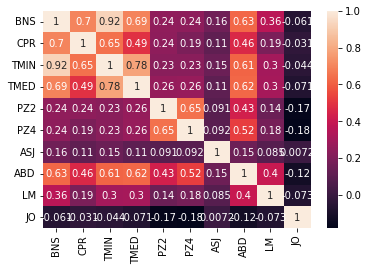

In [46]:
import pandas as pd
import seaborn as sns

test_stat_df = pd.DataFrame({"BNS" : ered_BNS,
                             "CPR" : ered_cpr,
                             "TMIN" : ered_min,
                             "TMED" : ered_med,
                             "PZ2" : ered_pz2,
                             "PZ4" : ered_pz4,
                             "ASJ" : ered_asj,
                             "ABD" : ered_abd,
                             "LM" : ered_lm,
                             "JO" : ered_jo})

corr = test_stat_df.corr()

# plot the heatmap
sns.heatmap(corr,annot = True)

In [45]:
test_stat_df.to_csv("Test_stat.csv")